### Install required packages

In [3]:
# Install all required packages
!pip -q install chess ipywidgets tensorflow scikit-learn pandas numpy matplotlib

import os
import pandas as pd
import numpy as np
import chess
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

print("Libraries installed successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries installed successfully!
TensorFlow version: 2.20.0


### Download the Chess Evaluations dataset from [Kaggle](https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations)

In [2]:
# Step 2: Download dataset from Kaggle

# Create .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the chess evaluations dataset
!kaggle datasets download -d ronakbadhe/chess-evaluations
!unzip -q chess-evaluations.zip
!rm chess-evaluations.zip

print("Dataset downloaded successfully!")

Dataset URL: https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations
License(s): other
^C
unzip:  cannot find or open chess-evaluations.zip, chess-evaluations.zip.zip or chess-evaluations.zip.ZIP.
rm: chess-evaluations.zip: No such file or directory
Dataset downloaded successfully!


In [14]:
# Load and explore the dataset
df = pd.read_csv('chessData.csv')
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nEvaluation score statistics:\n{df['Evaluation'].describe()}")


Dataset shape: (12958035, 2)

First few rows:
                                                 FEN Evaluation
0  rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...        -10
1  rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...        +56
2  rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...         -9
3  rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...        +52
4  rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...        -26

Column names: ['FEN', 'Evaluation']

Data types:
FEN           object
Evaluation    object
dtype: object

Missing values:
FEN           0
Evaluation    0
dtype: int64

Evaluation score statistics:
count     12958035
unique       13544
top              0
freq       1261356
Name: Evaluation, dtype: object


### 1. Data Preprocessing
- Convert FEN positions to numerical feature representations
- Normalize evaluation scores
- Split dataset into training and validation sets

In [15]:
# Step 3: Preprocess the data - Convert FEN positions to numerical features

def fen_to_board_array(fen):
    """
    Convert FEN string to a numerical board representation.
    Returns a 768-dimensional vector (8x8x12 flattened).
    12 channels: 6 piece types × 2 colors
    """
    board = chess.Board(fen)
    
    # Initialize 8x8x12 array (12 channels for piece types and colors)
    board_array = np.zeros((8, 8, 12), dtype=np.float32)
    
    # Piece type mapping
    piece_map = {
        chess.PAWN: 0,
        chess.KNIGHT: 1,
        chess.BISHOP: 2,
        chess.ROOK: 3,
        chess.QUEEN: 4,
        chess.KING: 5
    }
    
    # Fill the array
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            rank = chess.square_rank(square)
            file = chess.square_file(square)
            piece_type_idx = piece_map[piece.piece_type]
            
            # White pieces: channels 0-5, Black pieces: channels 6-11
            channel = piece_type_idx if piece.color == chess.WHITE else piece_type_idx + 6
            board_array[rank, file, channel] = 1.0
    
    # Flatten to 1D vector
    return board_array.flatten()

    # Starting position
fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
board_array = fen_to_board_array(fen)

print(f"Shape: {board_array.shape}")  # (768,) = 8×8×12 flattened
print(f"Min value: {board_array.min()}")  # 0.0
print(f"Max value: {board_array.max()}")  # 1.0
print(f"Unique values: {np.unique(board_array)}")  # [0. 1.]
print(f"Number of 1s: {np.sum(board_array)}")  # 32 (32 pieces on board)

Shape: (768,)
Min value: 0.0
Max value: 1.0
Unique values: [0. 1.]
Number of 1s: 32.0


In [16]:
def preprocess_evaluation(eval_str):
    """
    Convert evaluation string to numerical value.
    Handles both centipawn evaluations and mate scores.
    """
    eval_str = str(eval_str).strip()
    
    # Handle mate scores
    if eval_str.startswith('#'):
        mate_in = int(eval_str[1:])
        # Convert mate scores to large values (positive for white advantage)
        return 10000 if mate_in > 0 else -10000
    
    # Handle regular centipawn evaluations
    try:
        return float(eval_str)
    except:
        return 0.0

In [27]:
print("Converting FEN positions to numerical features...")
print("This may take a few minutes depending on dataset size...")

# Sample the dataset if it's too large (for faster training)
# Adjust sample_size based on your computational resources
sample_size = min(500000, len(df))  # Use up to 500k positions
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

print(f"Using {sample_size} positions for training")

# Convert FEN positions to feature vectors
X = np.array([fen_to_board_array(fen) for fen in df_sample['FEN']])
print(f"Feature matrix shape: {X.shape}")

# Convert evaluations to numerical values
y = np.array([preprocess_evaluation(eval_val) for eval_val in df_sample['Evaluation']])
print(f"Target vector shape: {y.shape}")

# Normalize evaluation scores to a reasonable range
# Clip extreme values and scale
y_clipped = np.clip(y, -5000, 5000)
scaler = StandardScaler()
y_normalized = scaler.fit_transform(y_clipped.reshape(-1, 1)).flatten()

print(f"\nOriginal evaluation range: [{y.min():.2f}, {y.max():.2f}]")
print(f"Clipped evaluation range: [{y_clipped.min():.2f}, {y_clipped.max():.2f}]")
print(f"Normalized evaluation range: [{y_normalized.min():.2f}, {y_normalized.max():.2f}]")

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_normalized, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Save the scaler for later use
with open('evaluation_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nData preprocessing complete!")

Converting FEN positions to numerical features...
This may take a few minutes depending on dataset size...
Using 500000 positions for training
Feature matrix shape: (500000, 768)
Target vector shape: (500000,)

Original evaluation range: [-14792.00, 10000.00]
Clipped evaluation range: [-5000.00, 5000.00]
Normalized evaluation range: [-5.43, 5.32]

Training set: 400000 samples
Test set: 100000 samples

Data preprocessing complete!


### 2. Design and Train a Neural Network model to evaluate chess positions

In [40]:
# Step 4: Design and train a neural network model

def create_chess_evaluation_model(input_dim=768):
    """
    Create a neural network for chess position evaluation.
    Architecture: Dense layers with dropout for regularization
    """
    model = keras.Sequential([
        keras.layers.Input(shape=(768,)),
        keras.layers.Dense(512, activation='relu'),  # ← Increased from 256
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation='relu'),  # ← Added layer
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),   # ← Added layer
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='linear')
    ])

    return model

In [41]:
# Create the model
print("Creating neural network model...")
model = create_chess_evaluation_model()

Creating neural network model...


In [43]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

In [ ]:
# Display model architecture
model.summary()

# Current: 50 epochs
# Try: 100 epochs with better callbacks

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint('chess_evaluation_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50, 
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

print("\nModel training complete!")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,698,821 (6.48 MB)

 Trainable params: 566,273 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,132,548 (4.32 MB)

Epoch 1/50
1245/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3127 - mae: 0.2795

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.3067 - mae: 0.2781 - val_loss: 0.7041 - val_mae: 0.3512 - learning_rate: 6.2500e-05
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2986 - mae: 0.2756 - val_loss: 0.7042 - val_mae: 0.3510 - learning_rate: 6.2500e-05
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2908 - mae: 0.2724 - val_loss: 0.7047 - val_mae: 0.3502 - learning_rate: 6.2500e-05
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2857 - mae: 0.2712 - val_loss: 0.7055 - val_mae: 0.3493 - learning_rate: 6.2500e-05
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2782 - mae: 0.2686 - val_loss: 0.7053 - val_mae: 0.3496 - learning_rate: 6.2500e-05
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2734 - mae: 0.2677 - val_loss: 0.7059 - val_mae: 0.3496 - learning_rate: 6.2500e-05
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2675 - mae: 0.2653 - val_loss: 0.7066 - val_mae: 0.3490 - l

In [51]:
# Evaluate the model
print("\nEvaluating model performance...")
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Save the trained model
model.save('chess_evaluation_model.h5')
print("\nModel saved as 'chess_evaluation_model.h5'")


Evaluating model performance...


Test Loss (MSE): 0.6984
Test MAE: 0.3470

Model saved as 'chess_evaluation_model.h5'


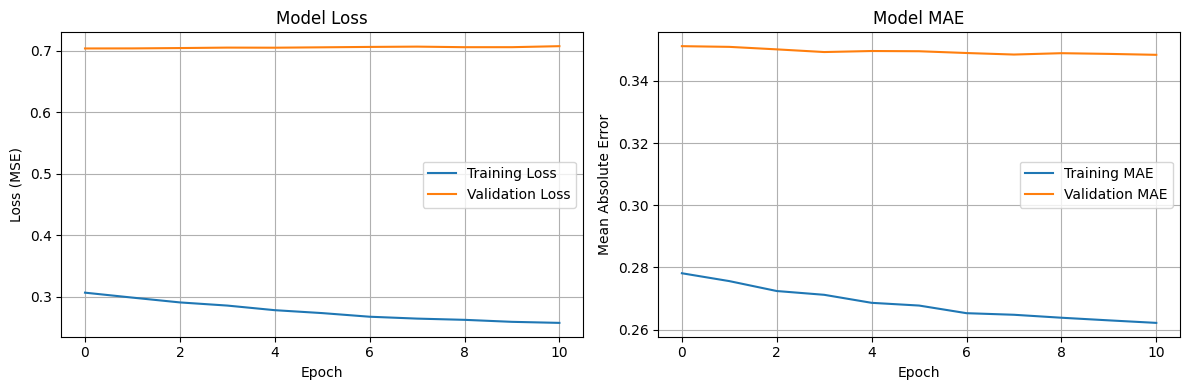

In [52]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Model MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Run the original chess game

In [59]:
import math
from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict

import chess
import ipywidgets as W
from IPython.display import display, HTML

# -------------------------------
#           ENGINE
# -------------------------------

PIECE_VALUES = {
    chess.PAWN:   100,
    chess.KNIGHT: 320,
    chess.BISHOP: 330,
    chess.ROOK:   500,
    chess.QUEEN:  900,
    chess.KING:   0,  # handled via mate scores
}

PAWN_TABLE = [
      0,  0,  0,  0,  0,  0,  0,  0,
     50, 50, 50, 50, 50, 50, 50, 50,
     10, 10, 20, 30, 30, 20, 10, 10,
      5,  5, 10, 25, 25, 10,  5,  5,
      0,  0,  0, 20, 20,  0,  0,  0,
      5, -5,-10,  0,  0,-10, -5,  5,
      5, 10, 10,-20,-20, 10, 10,  5,
      0,  0,  0,  0,  0,  0,  0,  0,
]
KNIGHT_TABLE = [
    -50,-40,-30,-30,-30,-30,-40,-50,
    -40,-20,  0,  5,  5,  0,-20,-40,
    -30,  5, 10, 15, 15, 10,  5,-30,
    -30,  0, 15, 20, 20, 15,  0,-30,
    -30,  5, 15, 20, 20, 15,  5,-30,
    -30,  0, 10, 15, 15, 10,  0,-30,
    -40,-20,  0,  0,  0,  0,-20,-40,
    -50,-40,-30,-30,-30,-30,-40,-50,
]
BISHOP_TABLE = [
    -20,-10,-10,-10,-10,-10,-10,-20,
    -10,  5,  0,  0,  0,  0,  5,-10,
    -10, 10, 10, 10, 10, 10, 10,-10,
    -10,  0, 10, 10, 10, 10,  0,-10,
    -10,  5,  5, 10, 10,  5,  5,-10,
    -10,  0,  5, 10, 10,  5,  0,-10,
    -10,  0,  0,  0,  0,  0,  0,-10,
    -20,-10,-10,-10,-10,-10,-10,-20,
]
ROOK_TABLE = [
     0,  0,  0,  5,  5,  0,  0,  0,
    -5,  0,  0,  0,  0,  0,  0, -5,
    -5,  0,  0,  0,  0,  0,  0, -5,
    -5,  0,  0,  0,  0,  0,  0, -5,
    -5,  0,  0,  0,  0,  0,  0, -5,
    -5,  0,  0,  0,  0,  0,  0, -5,
     5, 10, 10, 10, 10, 10, 10,  5,
     0,  0,  0,  0,  0,  0,  0,  0,
]
QUEEN_TABLE = [
    -20,-10,-10, -5, -5,-10,-10,-20,
    -10,  0,  5,  0,  0,  0,  0,-10,
    -10,  5,  5,  5,  5,  5,  0,-10,
     -5,  0,  5,  5,  5,  5,  0, -5,
      0,  0,  5,  5,  5,  5,  0, -5,
    -10,  0,  5,  5,  5,  5,  0,-10,
    -10,  0,  0,  0,  0,  0,  0,-10,
    -20,-10,-10, -5, -5,-10,-10,-20,
]
KING_TABLE = [
    -30,-40,-40,-50,-50,-40,-40,-30,
    -30,-40,-40,-50,-50,-40,-40,-30,
    -30,-40,-40,-50,-50,-40,-40,-30,
    -30,-40,-40,-50,-50,-40,-40,-30,
    -20,-30,-30,-40,-40,-30,-30,-20,
    -10,-20,-20,-20,-20,-20,-20,-10,
     20, 20,  0,  0,  0,  0, 20, 20,
     20, 30, 10,  0,  0, 10, 30, 20,
]
PST = {
    chess.PAWN:   PAWN_TABLE,
    chess.KNIGHT: KNIGHT_TABLE,
    chess.BISHOP: BISHOP_TABLE,
    chess.ROOK:   ROOK_TABLE,
    chess.QUEEN:  QUEEN_TABLE,
    chess.KING:   KING_TABLE
}
MATE_VALUE = 10_000

# NEW: Use ML evaluation
USE_ML_EVALUATION = True

# Update evaluate_board_raw to use ML evaluation
def evaluate_board_raw(board: chess.Board) -> int:
    """
    Updated evaluation function that can use either ML or original evaluation.
    """
    if USE_ML_EVALUATION:
        return evaluate_board_ml(board)
    else:   
        # original evaluation logic 
        if board.is_game_over():
            outcome = board.outcome()
            if outcome is None or outcome.winner is None:
                return 0
            return MATE_VALUE if outcome.winner == chess.WHITE else -MATE_VALUE

    score = 0
    for sq, piece in board.piece_map().items():
        base = PIECE_VALUES[piece.piece_type]
        if piece.color == chess.WHITE:
            score += base + PST[piece.piece_type][sq]
        else:
            score -= base + PST[piece.piece_type][chess.square_mirror(sq)]
    return score

def eval_for_color(board: chess.Board, ai_color: chess.Color) -> int:
    raw = evaluate_board_raw(board)
    return raw if ai_color == chess.WHITE else -raw

def move_order_key(board: chess.Board, move: chess.Move) -> int:
    score = 0
    if board.is_capture(move):
        captured = board.piece_type_at(move.to_square)
        attacker = board.piece_type_at(move.from_square)
        if captured:
            score += 10 * PIECE_VALUES[captured] - PIECE_VALUES.get(attacker, 0)
        else:
            score += 500
    if move.promotion:
        score += PIECE_VALUES.get(move.promotion, 0)
    board.push(move)
    if board.is_check():
        score += 50
    board.pop()
    return score

def ordered_moves(board: chess.Board) -> List[chess.Move]:
    ms = list(board.legal_moves)
    ms.sort(key=lambda m: move_order_key(board, m), reverse=True)
    return ms

def minimax(board: chess.Board, depth: int, alpha: int, beta: int, ai_color: chess.Color) -> Tuple[int, Optional[chess.Move]]:
    if depth == 0 or board.is_game_over():
        return eval_for_color(board, ai_color), None

    maximizing = (board.turn == ai_color)
    best_move = None

    if maximizing:
        best = -math.inf
        for mv in ordered_moves(board):
            board.push(mv)
            val, _ = minimax(board, depth - 1, alpha, beta, ai_color)
            board.pop()
            if val > best:
                best, best_move = val, mv
            alpha = max(alpha, best)
            if beta <= alpha:
                break
        return int(best), best_move
    else:
        best = math.inf
        for mv in ordered_moves(board):
            board.push(mv)
            val, _ = minimax(board, depth - 1, alpha, beta, ai_color)
            board.pop()
            if val < best:
                best, best_move = val, mv
            beta = min(beta, best)
            if beta <= alpha:
                break
        return int(best), best_move

def best_move(board: chess.Board, depth: int, ai_color: chess.Color) -> Optional[chess.Move]:
    score, mv = minimax(board, depth, -math.inf, math.inf, ai_color)
    return mv

# -------------------------------
#           UI (ipywidgets)
# -------------------------------

# Piece glyphs
GLYPH = {
    'P':'♙','N':'♘','B':'♗','R':'♖','Q':'♕','K':'♔',
    'p':'♟','n':'♞','b':'♝','r':'♜','q':'♛','k':'♚',
}
LIGHT = '#F0D9B5'
DARK  = '#B58863'
SEL   = '#f6f67a'
TARGET= '#b9e6a1'
CAPT  = '#f5a3a3'

# Optional: bump button font-size
display(HTML("<style>.widget-button{font-size:22px !important;}</style>"))

@dataclass
class GameState:
    board: chess.Board
    ai_color: Optional[chess.Color]  # None for 2-player mode
    depth: int
    orientation_white: bool  # True = white-bottom view

    def status_text(self) -> str:
        if self.board.is_game_over():
            outcome = self.board.outcome()
            if outcome is None or outcome.winner is None:
                return "Game over · Draw"
            return "Game over · " + ("White wins" if outcome.winner == chess.WHITE else "Black wins")
        who = "White" if self.board.turn == chess.WHITE else "Black"
        check = " · Check!" if self.board.is_check() else ""
        return f"Turn: {who}{check}"
        

class ChessApp:
    def __init__(self):
        # Controls
        self.mode = W.ToggleButtons(options=[('Vs AI','ai'),('Two Players','2p')], value='ai', description='Mode:')
        self.color_sel = W.ToggleButtons(options=[('White','white'),('Black','black')], value='white', description='You:')
        self.depth = W.IntSlider(value=3, min=2, max=5, step=1, description='AI depth:')
        self.start_btn = W.Button(description='Start / Reset', button_style='primary')
        self.undo_btn = W.Button(description='Undo')
        self.flip_btn = W.Button(description='Flip')
        self.status = W.HTML("<b>Click Start / Reset to begin.</b>")
        self.log = W.HTML("")
        self.log_box = W.VBox([W.HTML("<b>Moves</b>"), W.Box([self.log], layout=W.Layout(max_height='300px', overflow='auto'))])

        # Promotion chooser (hidden until needed)
        self.promo_box = W.HBox([])
        self._promo_pending = None  # (from_sq, to_sq)

        # Board grid
        self.grid_box = W.GridBox(children=[], layout=W.Layout(grid_template_columns='repeat(8, 46px)', grid_gap='0px'))
        self.sq_buttons: Dict[int, W.Button] = {}  # square -> button
        self.selected_sq: Optional[int] = None
        self.legal_from_selected: List[chess.Move] = []

        # State
        self.state: Optional[GameState] = None

        # Wire controls
        self.start_btn.on_click(self.on_start)
        self.undo_btn.on_click(self.on_undo)
        self.flip_btn.on_click(self.on_flip)
        self.mode.observe(self.on_mode_change, 'value')

        # Build panel
        top = W.HBox([self.mode, self.color_sel, self.depth, self.start_btn, self.undo_btn, self.flip_btn])
        self.ui = W.VBox([top, self.status, self.promo_box, W.HBox([self.grid_box, self.log_box])])

        self._build_empty_grid()
        display(self.ui)

    # ---------- helpers ----------
    def _square_to_rc(self, sq: int) -> Tuple[int,int]:
        """Return (row, col) on the 8x8 grid for a given 0..63 square, given orientation."""
        file = chess.square_file(sq)
        rank = chess.square_rank(sq)
        if self.state and self.state.orientation_white:
            row = 7 - rank
            col = file
        else:
            row = rank
            col = 7 - file
        return row, col

    def _rc_to_square(self, row: int, col: int) -> int:
        """Return 0..63 square for grid (row, col)."""
        if self.state and self.state.orientation_white:
            rank = 7 - row
            file = col
        else:
            rank = row
            file = 7 - col
        return chess.square(file, rank)

    def _build_empty_grid(self):
        self.grid_box.children = ()
        self.sq_buttons.clear()
        children = []
        for row in range(8):
            for col in range(8):
                sq = self._rc_to_square(row, col)
                light = (row + col) % 2 == 0
                b = W.Button(description=' ', layout=W.Layout(width='46px', height='46px', padding='0'),
                             tooltip=chess.square_name(sq))
                b.style.button_color = LIGHT if light else DARK
                b.on_click(self._make_square_click(sq))
                self.sq_buttons[sq] = b
                children.append(b)
        self.grid_box.children = tuple(children)

    def _render_board(self):
        board = self.state.board
        # Clear any highlights if selection disappeared
        if self.selected_sq is not None and (self.selected_sq not in [m.from_square for m in board.legal_moves]):
            self.selected_sq = None
            self.legal_from_selected = []
        # Set base colors & glyphs
        for sq, btn in self.sq_buttons.items():
            row, col = self._square_to_rc(sq)
            light = (row + col) % 2 == 0
            btn.style.button_color = LIGHT if light else DARK
            piece = board.piece_at(sq)
            btn.description = GLYPH.get(piece.symbol(), ' ') if piece else ' '
        # Highlight selection and legal targets
        if self.selected_sq is not None:
            self.sq_buttons[self.selected_sq].style.button_color = SEL
            targets = [m.to_square for m in self.legal_from_selected]
            for m in self.legal_from_selected:
                tgt = m.to_square
                btn = self.sq_buttons[tgt]
                btn.style.button_color = CAPT if self.state.board.is_capture(m) else TARGET

        # Update status
        self.status.value = f"<b>{self.state.status_text()}</b>"

    def _append_log(self, text: str):
        self.log.value += f"{text}<br>"
        # cap log length a bit
        if self.log.value.count("<br>") > 200:
            self.log.value = "<i>(trimmed)</i><br>" + "<br>".join(self.log.value.split("<br>")[-200:])

    def _make_square_click(self, sq: int):
        def handler(_):
            if self.state is None or self.state.board.is_game_over():
                return
            # If promotion dialog visible, ignore board clicks
            if self._promo_pending is not None:
                return

            board = self.state.board

            # Whose turn is allowed to move?
            if self.state.ai_color is not None:
                human_turn = (board.turn != self.state.ai_color)
                if not human_turn:
                    return  # wait for AI
            # In 2-player mode both can move

            piece = board.piece_at(sq)
            if self.selected_sq is None:
                # First click: must be a piece of side to move
                if piece is None or piece.color != board.turn:
                    return
                self.selected_sq = sq
                self.legal_from_selected = [m for m in board.legal_moves if m.from_square == sq]
                self._render_board()
                return
            else:
                # Second click: attempt move
                if sq == self.selected_sq:
                    self.selected_sq = None
                    self.legal_from_selected = []
                    self._render_board()
                    return

                # Allow reselecting another own piece
                if piece is not None and piece.color == board.turn:
                    self.selected_sq = sq
                    self.legal_from_selected = [m for m in board.legal_moves if m.from_square == sq]
                    self._render_board()
                    return

                # Try to move selected -> sq (with possible promotion)
                legal_targets = [m for m in self.legal_from_selected if m.to_square == sq]
                if not legal_targets:
                    return

                # Promotion handling: if any candidate has a promotion, ask
                promos = [m for m in legal_targets if m.promotion]
                if promos:
                    self._prompt_promotion(self.selected_sq, sq, promos)
                    return

                # Otherwise, there should be exactly one legal move
                mv = legal_targets[0]
                self._play_human_move(mv)
        return handler

    def _prompt_promotion(self, from_sq: int, to_sq: int, promo_moves: List[chess.Move]):
        # Show small chooser
        self._promo_pending = (from_sq, to_sq)
        opts = [('Queen','q'),('Rook','r'),('Bishop','b'),('Knight','n')]
        picker = W.ToggleButtons(options=opts, value='q', description='Promote:')
        ok_btn = W.Button(description='OK', button_style='success')
        cancel_btn = W.Button(description='Cancel')
        msg = W.HTML("")

        def on_ok(_):
            letter = picker.value
            promo_map = {'q':chess.QUEEN,'r':chess.ROOK,'b':chess.BISHOP,'n':chess.KNIGHT}
            promo_piece = promo_map[letter]
            # find matching legal move
            for m in promo_moves:
                if m.from_square == from_sq and m.to_square == to_sq and m.promotion == promo_piece:
                    self._clear_promo_ui()
                    self._play_human_move(m)
                    return
            msg.value = "<span style='color:#b91c1c'>Not a legal promotion.</span>"

        def on_cancel(_):
            self._clear_promo_ui()
            # keep selection so user can try again

        ok_btn.on_click(on_ok)
        cancel_btn.on_click(on_cancel)
        self.promo_box.children = [picker, ok_btn, cancel_btn, msg]

    def _clear_promo_ui(self):
        self.promo_box.children = []
        self._promo_pending = None

    # ---------- actions ----------
    def on_start(self, _):
        human_color = self.color_sel.value
        ai = (None if self.mode.value == '2p'
              else (chess.BLACK if human_color == 'white' else chess.WHITE))
        self.state = GameState(board=chess.Board(), ai_color=ai, depth=int(self.depth.value),
                               orientation_white=True if human_color=='white' else False)
        self.selected_sq = None
        self.legal_from_selected = []
        self._build_empty_grid()
        self.log.value = ""
        self._clear_promo_ui()

        # If AI plays first (AI = white)
        if self.state.ai_color == chess.WHITE and self.state.board.turn == chess.WHITE:
            mv = best_move(self.state.board, self.state.depth, self.state.ai_color)
            if mv:
                san = self.state.board.san(mv)
                self.state.board.push(mv)
                self._append_log(f"AI: {san}")
        self._render_board()

    def on_undo(self, _):
        if not self.state: return
        b = self.state.board
        undone = 0
        if len(b.move_stack): b.pop(); undone += 1
        if self.state.ai_color is not None and len(b.move_stack):
            # try undo a full pair vs AI
            b.pop(); undone += 1
        self.selected_sq = None
        self.legal_from_selected = []
        self._append_log(f"<i>Undid {undone} half-move(s).</i>")
        self._render_board()

    def on_flip(self, _):
        if not self.state: return
        self.state.orientation_white = not self.state.orientation_white
        self._build_empty_grid()
        self._render_board()

    def on_mode_change(self, change):
        # Enable/disable controls based on mode
        is_ai = change['new'] == 'ai'
        self.color_sel.disabled = not is_ai
        self.depth.disabled = not is_ai

    def _play_human_move(self, mv: chess.Move):
        b = self.state.board
        san = b.san(mv)
        b.push(mv)
        self._append_log(f"You: {san}")
        self.selected_sq = None
        self.legal_from_selected = []
        self._render_board()
        # If game not over and vs AI, let AI respond
        if not b.is_game_over() and self.state.ai_color is not None and b.turn == self.state.ai_color:
            reply = best_move(b, self.state.depth, self.state.ai_color)
            if reply:
                san2 = b.san(reply)
                b.push(reply)
                self._append_log(f"AI: {san2}")
                self._render_board()

# Launch the app
ChessApp()


AttributeError: 'tuple' object has no attribute 'drop'

### Create ML-based evaluation function

In [62]:
# Load the trained model and scaler
loaded_model = keras.models.load_model('./chess_evaluation_model.h5')
with open('evaluation_scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

print("Model and scaler loaded successfully!")

eval_cache = {}

def evaluate_board_ml(board: chess.Board) -> int:
    """
    ML-based board evaluation function.
    Replaces the original evaluate_board_raw() function.
    """
    # Check cache first
    fen_key = board.fen().split()[0]  # Position only
    if fen_key in eval_cache:
        return eval_cache[fen_key]

    # Handle game-over positions
    if board.is_game_over():
        outcome = board.outcome()
        if outcome is None or outcome.winner is None:
            return 0
        return MATE_VALUE if outcome.winner == chess.WHITE else -MATE_VALUE
    
    # Convert board to FEN and then to feature vector
    fen = board.fen()
    features = fen_to_board_array(fen).reshape(1, -1)
    
    # Get prediction from ML model
    normalized_prediction = loaded_model.predict(features, verbose=0)[0][0]
    
    # Inverse transform to get actual evaluation score
    actual_evaluation = loaded_scaler.inverse_transform([[normalized_prediction]])[0][0]
    score = int(actual_evaluation)

    # Cache the result
    eval_cache[fen_key] = score
    
    # Convert to integer centipawns
    return score

# Test the ML evaluation function
print("\nTesting ML evaluation function...")
test_board = chess.Board()

print(f"Starting position FEN: {test_board.fen()}")
print(f"ML Evaluation: {evaluate_board_ml(test_board)}")
print(f"Original Evaluation: {evaluate_board_raw(test_board)}")

# Test a few moves
test_board.push_san("e4")
print(f"\nAfter 1.e4:")
print(f"ML Evaluation: {evaluate_board_ml(test_board)}")
print(f"Original Evaluation: {evaluate_board_raw(test_board)}")

test_board.push_san("e5")
print(f"\nAfter 1.e4 e5:")
print(f"ML Evaluation: {evaluate_board_ml(test_board)}")
print(f"Original Evaluation: {evaluate_board_raw(test_board)}")

print("\nML evaluation function is working!")

Model and scaler loaded successfully!

Testing ML evaluation function...
Starting position FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
ML Evaluation: 46
Original Evaluation: 46

After 1.e4:
ML Evaluation: 49
Original Evaluation: 49

After 1.e4 e5:
ML Evaluation: 48
Original Evaluation: 48

ML evaluation function is working!


### Run Chess Minimax with ML Evaluation

In [64]:
import math
from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict
import time
import random

import chess
import ipywidgets as W
from IPython.display import display, HTML

# -------------------------------
#           ENGINE
# -------------------------------

PIECE_VALUES = {
    chess.PAWN:   100,
    chess.KNIGHT: 320,
    chess.BISHOP: 330,
    chess.ROOK:   500,
    chess.QUEEN:  900,
    chess.KING:   0,
}

PAWN_TABLE = [
      0,  0,  0,  0,  0,  0,  0,  0,
     50, 50, 50, 50, 50, 50, 50, 50,
     10, 10, 20, 30, 30, 20, 10, 10,
      5,  5, 10, 25, 25, 10,  5,  5,
      0,  0,  0, 20, 20,  0,  0,  0,
      5, -5,-10,  0,  0,-10, -5,  5,
      5, 10, 10,-20,-20, 10, 10,  5,
      0,  0,  0,  0,  0,  0,  0,  0,
]
KNIGHT_TABLE = [
    -50,-40,-30,-30,-30,-30,-40,-50,
    -40,-20,  0,  5,  5,  0,-20,-40,
    -30,  5, 10, 15, 15, 10,  5,-30,
    -30,  0, 15, 20, 20, 15,  0,-30,
    -30,  5, 15, 20, 20, 15,  5,-30,
    -30,  0, 10, 15, 15, 10,  0,-30,
    -40,-20,  0,  0,  0,  0,-20,-40,
    -50,-40,-30,-30,-30,-30,-40,-50,
]
BISHOP_TABLE = [
    -20,-10,-10,-10,-10,-10,-10,-20,
    -10,  5,  0,  0,  0,  0,  5,-10,
    -10, 10, 10, 10, 10, 10, 10,-10,
    -10,  0, 10, 10, 10, 10,  0,-10,
    -10,  5,  5, 10, 10,  5,  5,-10,
    -10,  0,  5, 10, 10,  5,  0,-10,
    -10,  0,  0,  0,  0,  0,  0,-10,
    -20,-10,-10,-10,-10,-10,-10,-20,
]
ROOK_TABLE = [
     0,  0,  0,  5,  5,  0,  0,  0,
    -5,  0,  0,  0,  0,  0,  0, -5,
    -5,  0,  0,  0,  0,  0,  0, -5,
    -5,  0,  0,  0,  0,  0,  0, -5,
    -5,  0,  0,  0,  0,  0,  0, -5,
    -5,  0,  0,  0,  0,  0,  0, -5,
     5, 10, 10, 10, 10, 10, 10,  5,
     0,  0,  0,  0,  0,  0,  0,  0,
]
QUEEN_TABLE = [
    -20,-10,-10, -5, -5,-10,-10,-20,
    -10,  0,  5,  0,  0,  0,  0,-10,
    -10,  5,  5,  5,  5,  5,  0,-10,
     -5,  0,  5,  5,  5,  5,  0, -5,
      0,  0,  5,  5,  5,  5,  0, -5,
    -10,  0,  5,  5,  5,  5,  0,-10,
    -10,  0,  0,  0,  0,  0,  0,-10,
    -20,-10,-10, -5, -5,-10,-10,-20,
]
KING_TABLE = [
    -30,-40,-40,-50,-50,-40,-40,-30,
    -30,-40,-40,-50,-50,-40,-40,-30,
    -30,-40,-40,-50,-50,-40,-40,-30,
    -30,-40,-40,-50,-50,-40,-40,-30,
    -20,-30,-30,-40,-40,-30,-30,-20,
    -10,-20,-20,-20,-20,-20,-20,-10,
     20, 20,  0,  0,  0,  0, 20, 20,
     20, 30, 10,  0,  0, 10, 30, 20,
]
PST = {
    chess.PAWN:   PAWN_TABLE,
    chess.KNIGHT: KNIGHT_TABLE,
    chess.BISHOP: BISHOP_TABLE,
    chess.ROOK:   ROOK_TABLE,
    chess.QUEEN:  QUEEN_TABLE,
    chess.KING:   KING_TABLE
}
MATE_VALUE = 10_000

# NEW: Use ML evaluation
USE_ML_EVALUATION = True

# Update evaluate_board_raw to use ML evaluation
def evaluate_board_raw(board: chess.Board) -> int:
    """
    Updated evaluation function that can use either ML or original evaluation.
    """
    if USE_ML_EVALUATION:
        return evaluate_board_ml(board)
    else:   
        # original evaluation logic 
        if board.is_game_over():
            outcome = board.outcome()
            if outcome is None or outcome.winner is None:
                return 0
            return MATE_VALUE if outcome.winner == chess.WHITE else -MATE_VALUE

    score = 0
    for sq, piece in board.piece_map().items():
        base = PIECE_VALUES[piece.piece_type]
        if piece.color == chess.WHITE:
            score += base + PST[piece.piece_type][sq]
        else:
            score -= base + PST[piece.piece_type][chess.square_mirror(sq)]
    return score

def eval_for_color(board: chess.Board, ai_color: chess.Color) -> int:
    raw = evaluate_board_raw(board)
    return raw if ai_color == chess.WHITE else -raw

def move_order_key(board: chess.Board, move: chess.Move) -> int:
    score = 0
    if board.is_capture(move):
        captured = board.piece_type_at(move.to_square)
        attacker = board.piece_type_at(move.from_square)
        if captured:
            score += 10 * PIECE_VALUES[captured] - PIECE_VALUES.get(attacker, 0)
        else:
            score += 500
    if move.promotion:
        score += PIECE_VALUES.get(move.promotion, 0)
    board.push(move)
    if board.is_check():
        score += 50
    board.pop()
    return score

def ordered_moves(board: chess.Board) -> List[chess.Move]:
    ms = list(board.legal_moves)
    ms.sort(key=lambda m: move_order_key(board, m), reverse=True)
    return ms

def minimax(board: chess.Board, depth: int, alpha: int, beta: int, ai_color: chess.Color) -> Tuple[int, Optional[chess.Move]]:
    if depth == 0 or board.is_game_over():
        return eval_for_color(board, ai_color), None

    maximizing = (board.turn == ai_color)
    best_move = None

    if maximizing:
        best = -math.inf
        for mv in ordered_moves(board):
            board.push(mv)
            val, _ = minimax(board, depth - 1, alpha, beta, ai_color)
            board.pop()
            if val > best:
                best, best_move = val, mv
            alpha = max(alpha, best)
            if beta <= alpha:
                break
        return int(best), best_move
    else:
        best = math.inf
        for mv in ordered_moves(board):
            board.push(mv)
            val, _ = minimax(board, depth - 1, alpha, beta, ai_color)
            board.pop()
            if val < best:
                best, best_move = val, mv
            beta = min(beta, best)
            if beta <= alpha:
                break
        return int(best), best_move

def best_move(board: chess.Board, depth: int, ai_color: chess.Color) -> Tuple[Optional[chess.Move], List[Tuple[str, int]]]:
    """
    Returns the best move and a list of all moves with their scores.
    Returns: (best_move, [(move_san, score), ...])
    """
    move_scores = []
    best_score = -math.inf if board.turn == ai_color else math.inf
    best_mv = None
    
    for mv in ordered_moves(board):
        board.push(mv)
        score, _ = minimax(board, depth - 1, -math.inf, math.inf, ai_color)
        board.pop()
        
        san = board.san(mv)
        move_scores.append((san, score))
        
        if board.turn == ai_color:
            if score > best_score:
                best_score = score
                best_mv = mv
        else:
            if score < best_score:
                best_score = score
                best_mv = mv
    
    # Sort by score (descending for maximizing, ascending for minimizing)
    move_scores.sort(key=lambda x: x[1], reverse=(board.turn == ai_color))
    
    return best_mv, move_scores

# -------------------------------
#           UI (ipywidgets)
# -------------------------------

GLYPH = {
    'P':'♙','N':'♘','B':'♗','R':'♖','Q':'♕','K':'♔',
    'p':'♟','n':'♞','b':'♝','r':'♜','q':'♛','k':'♚',
}
LIGHT = '#F0D9B5'
DARK  = '#B58863'
SEL   = '#f6f67a'
TARGET= '#b9e6a1'
CAPT  = '#f5a3a3'
ANALYZING = '#87CEEB'  # Sky blue for analyzing moves
AI_MOVE = '#ff6b6b'  # Red for AI's last move
USER_MOVE = '#6b9eff'    # Blue for user's last move
CASTLING_KING = '#9d6bff'   # Purple for King in castling
CASTLING_ROOK = '#ffa500'   # Orange for Rook in castling

display(HTML("<style>.widget-button{font-size:22px !important;}</style>"))

@dataclass
class GameState:
    board: chess.Board
    ai_color: Optional[chess.Color]
    depth: int
    orientation_white: bool

    def status_text(self) -> str:
        if self.board.is_game_over():
            outcome = self.board.outcome()
            if outcome is None or outcome.winner is None:
                return "Game over · Draw"
            return "Game over · " + ("White wins" if outcome.winner == chess.WHITE else "Black wins")
        who = "White" if self.board.turn == chess.WHITE else "Black"
        check = " · Check!" if self.board.is_check() else ""
        return f"Turn: {who}{check}"

class ChessApp:
    def __init__(self):
        self.mode = W.ToggleButtons(options=[('Vs AI','ai'),('Two Players','2p')], value='ai', description='Mode:')
        self.color_sel = W.ToggleButtons(options=[('White','white'),('Black','black')], value='white', description='You:')
        self.depth = W.IntSlider(value=3, min=2, max=5, step=1, description='AI depth:')
        self.start_btn = W.Button(description='Start / Reset', button_style='primary')
        self.undo_btn = W.Button(description='Undo')
        self.flip_btn = W.Button(description='Flip')
        self.status = W.HTML("<b>Click Start / Reset to begin.</b>")
        self.log = W.HTML("")

        # Updated log_box with border and styling
        self.log_box = W.VBox([
            W.HTML("<b>Moves</b>"), 
            W.Box([self.log], layout=W.Layout(
                max_height='220px', 
                overflow='auto',
                border='2px solid #B58863',
                box_shadow='0 2px 8px rgba(0,0,0,0.1)',  # Subtle shadow
                padding='12px',
                background_color='#F0D9B5'
            ))
        ], layout=W.Layout(margin='0 0 0 30px'))

        # NEW: Add statistics panel
        self.stats = W.HTML("")
        self.stats_box = W.VBox([
            W.HTML("<b>AI Analysis</b>"), 
            W.Box([self.stats], layout=W.Layout(
                max_height='368px', 
                overflow='auto',
                border='2px solid #B58863',
                box_shadow='0 2px 8px rgba(0,0,0,0.1)',
                padding='12px',
                background_color='#F0D9B5'
            ))
        ], layout=W.Layout(margin='0 0 0 30px'))

        self.promo_box = W.HBox([])
        self._promo_pending = None

        # NEW: Track AI and user's last move
        self.ai_last_move = None
        self.user_last_move = None
        self.user_castling_squares = []  # Store all squares involved in user's castling
        self.ai_castling_squares = []    # Store all squares involved in AI's castling

        self.grid_box = W.GridBox(children=[], layout=W.Layout(grid_template_columns='repeat(8, 46px)', grid_gap='0px'))
        self.sq_buttons: Dict[int, W.Button] = {}
        self.selected_sq: Optional[int] = None
        self.legal_from_selected: List[chess.Move] = []

        self.state: Optional[GameState] = None

        self.start_btn.on_click(self.on_start)
        self.undo_btn.on_click(self.on_undo)
        self.flip_btn.on_click(self.on_flip)
        self.mode.observe(self.on_mode_change, 'value')

        top = W.HBox([self.mode, self.color_sel, self.depth, self.start_btn, self.undo_btn, self.flip_btn])
        # Create placeholder for board with labels
        self.board_container = W.VBox([])
        self.ui = W.VBox([top, self.status, self.promo_box, W.HBox([self.board_container, self.log_box, self.stats_box])])

        self._build_empty_grid()
        display(self.ui)
    
    def _create_board_with_labels(self):
        """Create chess board with coordinate labels (a-h, 1-8)."""
        
        # Create file labels (a-h) at the bottom
        file_labels = []
        files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
        if not self.state or not self.state.orientation_white:
            files = files[::-1]  # Reverse for black's perspective
        
        for file_letter in files:
            label = W.HTML(
                f"<div style='width:46px; text-align:center; font-weight:bold; color:#666;'>{file_letter}</div>"
            )
            file_labels.append(label)
        
        # Create rank labels (1-8) on the left side
        rank_labels = []
        ranks = ['8', '7', '6', '5', '4', '3', '2', '1']
        if not self.state or not self.state.orientation_white:
            ranks = ranks[::-1]  # Reverse for black's perspective
        
        for rank_num in ranks:
            label = W.HTML(
                f"<div style='height:46px; width:20px; display:flex; align-items:center; justify-content:center; font-weight:bold; color:#666;'>{rank_num}</div>"
            )
            rank_labels.append(label)
        
        # Create rows with rank labels + board squares
        board_rows = []
        for i in range(8):
            row_squares = []
            for j in range(8):
                sq_index = i * 8 + j
                row_squares.append(self.grid_box.children[sq_index])
            
            # Add rank label + 8 squares for this row
            row = W.HBox([rank_labels[i]] + row_squares, layout=W.Layout(margin='0'))
            board_rows.append(row)
        
        # Add empty corner space + file labels at bottom
        corner_space = W.HTML("<div style='width:20px; height:20px;'></div>")
        bottom_labels = W.HBox([corner_space] + file_labels, layout=W.Layout(margin='0'))
        
        # Combine everything vertically
        board_with_labels = W.VBox(board_rows + [bottom_labels], layout=W.Layout(margin='0'))
        
        return board_with_labels

    def _square_to_rc(self, sq: int) -> Tuple[int,int]:
        file = chess.square_file(sq)
        rank = chess.square_rank(sq)
        if self.state and self.state.orientation_white:
            row = 7 - rank
            col = file
        else:
            row = rank
            col = 7 - file
        return row, col

    def _rc_to_square(self, row: int, col: int) -> int:
        if self.state and self.state.orientation_white:
            rank = 7 - row
            file = col
        else:
            rank = row
            file = 7 - col
        return chess.square(file, rank)

    def _build_empty_grid(self):
        # self.grid_box.children = ()
        # self.sq_buttons.clear()
        # children = []
        # for row in range(8):
        #     for col in range(8):
        #         sq = self._rc_to_square(row, col)
        #         light = (row + col) % 2 == 0
        #         b = W.Button(description=' ', layout=W.Layout(width='46px', height='46px', padding='0'),
        #                      tooltip=chess.square_name(sq))
        #         b.style.button_color = LIGHT if light else DARK
        #         b.on_click(self._make_square_click(sq))
        #         self.sq_buttons[sq] = b
        #         children.append(b)
        # self.grid_box.children = tuple(children)
        buttons = []
        for r in range(8):
            for c in range(8):
                sq = self._rc_to_square(r, c)
                light = (r + c) % 2 == 0
                btn = W.Button(description=' ', layout=W.Layout(width='46px', height='46px'))
                btn.style.button_color = LIGHT if light else DARK
                btn.on_click(self._make_square_click(sq)) 
                self.sq_buttons[sq] = btn
                buttons.append(btn)
        self.grid_box.children = buttons

        # Update the board container with labels
        self.board_container.children = [self._create_board_with_labels()]

    def _render_board(self, highlight_move: Optional[chess.Move] = None):
        """Render board with optional move highlighting."""
        board = self.state.board
        if self.selected_sq is not None and (self.selected_sq not in [m.from_square for m in board.legal_moves]):
            self.selected_sq = None
            self.legal_from_selected = []
        
        # Set base colors & glyphs
        for sq, btn in self.sq_buttons.items():
            row, col = self._square_to_rc(sq)
            light = (row + col) % 2 == 0
            btn.style.button_color = LIGHT if light else DARK
            piece = board.piece_at(sq)
            btn.description = GLYPH.get(piece.symbol(), ' ') if piece else ' '
        
        # Highlight analyzing move
        if highlight_move:
            self.sq_buttons[highlight_move.from_square].style.button_color = ANALYZING
            self.sq_buttons[highlight_move.to_square].style.button_color = ANALYZING

        # Highlight AI's last move in RED
        if self.ai_last_move is not None:
            if self.ai_castling_squares:
                # Highlight King squares (from and to) in PURPLE
                self.sq_buttons[self.ai_castling_squares[0]].style.button_color = CASTLING_KING
                self.sq_buttons[self.ai_castling_squares[1]].style.button_color = CASTLING_KING
                # Highlight Rook squares (from and to) in ORANGE
                self.sq_buttons[self.ai_castling_squares[2]].style.button_color = CASTLING_ROOK
                self.sq_buttons[self.ai_castling_squares[3]].style.button_color = CASTLING_ROOK
            else:
                # Normal move: highlight from and to
                self.sq_buttons[self.ai_last_move.from_square].style.button_color = AI_MOVE
                self.sq_buttons[self.ai_last_move.to_square].style.button_color = AI_MOVE

        # Highlight user's last move in BLUE
        if self.user_last_move is not None:
            if self.user_castling_squares:
                # Highlight King squares (from and to) in PURPLE
                self.sq_buttons[self.user_castling_squares[0]].style.button_color = CASTLING_KING
                self.sq_buttons[self.user_castling_squares[1]].style.button_color = CASTLING_KING
                # Highlight Rook squares (from and to) in ORANGE
                self.sq_buttons[self.user_castling_squares[2]].style.button_color = CASTLING_ROOK
                self.sq_buttons[self.user_castling_squares[3]].style.button_color = CASTLING_ROOK
            else:
                # Normal move: highlight from and to
                self.sq_buttons[self.user_last_move.from_square].style.button_color = USER_MOVE
                self.sq_buttons[self.user_last_move.to_square].style.button_color = USER_MOVE
        
        # Highlight selection and legal targets
        if self.selected_sq is not None:
            self.sq_buttons[self.selected_sq].style.button_color = SEL
            for m in self.legal_from_selected:
                btn = self.sq_buttons[m.to_square]
                btn.style.button_color = CAPT if self.state.board.is_capture(m) else TARGET

        self.status.value = f"<b>{self.state.status_text()}</b>"

    # def _animate_move_preview(self, move: chess.Move, move_san: str):
    #     """Show a visual preview of a move being analyzed."""
    #     # Highlight the move
    #     self._render_board(highlight_move=move)
    #     self.status.value = f"<b>🤔 Analyzing: {move_san}...</b>"
    #     time.sleep(0.4)
        
    #     # Show the move temporarily
    #     board = self.state.board
    #     board.push(move)
    #     self._render_board()
    #     time.sleep(0.3)
        
    #     # Undo the preview
    #     board.pop()
    #     self._render_board()

    def _append_log(self, text: str):
        import time
        move_id = f"move-{int(time.time() * 1000)}"
        self.log.value += f'<div id="{move_id}">{text}</div>'
        if self.log.value.count("<div") > 200:
            lines = self.log.value.split("</div>")
            self.log.value = "<i>(trimmed)</i><br>" + "</div>".join(lines[-200:])
        
        # Auto-scroll using JavaScript
        from IPython.display import display, Javascript
        display(Javascript(f'''
            setTimeout(function() {{
                var container = document.querySelector('.chess-moves-log');
                if (container) {{
                    container.scrollTop = container.scrollHeight;
                }}
                var elem = document.getElementById('{move_id}');
                if (elem) {{
                    elem.scrollIntoView({{behavior: 'smooth', block: 'end'}});
                }}
            }}, 100);
        '''))

    def _update_stats(self, move_scores: List[Tuple[str, int]], best_move: str):
        """Update the statistics panel with move analysis."""
        html = f"<div style='font-family: monospace; font-size: 12px;'>"
        html += f"<div style='margin-bottom: 10px; padding: 5px; background-color: #d4e6c8; border-radius: 3px;'>"
        html += f"<b>Best Move: {best_move}</b> (Score: {move_scores[0][1]:+d})"
        html += f"</div>"
        html += f"<div style='margin-bottom: 5px;'><b>All Moves ({len(move_scores)} total):</b></div>"
        
        for i, (move, score) in enumerate(move_scores[:15]):
            # Color code based on score relative to best
            if i == 0:
                color = '#d4e6c8'  # Best move - green
            elif score == move_scores[0][1]:
                color = '#e8f5e8'  # Equal to best - light green
            elif abs(score - move_scores[0][1]) <= 10:
                color = '#fff9e6'  # Close to best - light yellow
            else:
                color = '#ffffff'  # Worse - white
                
            html += f"<div style='padding: 2px 5px; background-color: {color}; margin-bottom: 2px; border-radius: 2px;'>"
            html += f"{i+1}. <b>{move}</b>: {score:+d}"
            
            # Show difference from best
            if i > 0:
                diff = score - move_scores[0][1]
                html += f" <span style='color: #888; font-size: 10px;'>({diff:+d})</span>"
            
            html += f"</div>"
        
        if len(move_scores) > 15:
            html += f"<div style='padding: 5px; font-style: italic; color: #666;'>... and {len(move_scores) - 15} more moves</div>"
        
        html += "</div>"
        self.stats.value = html

    def _get_piece_name(self, piece_type: int) -> str:
        """Get the full name of a chess piece."""
        piece_names = {
            chess.PAWN: "Pawn",
            chess.KNIGHT: "Knight",
            chess.BISHOP: "Bishop",
            chess.ROOK: "Rook",
            chess.QUEEN: "Queen",
            chess.KING: "King"
        }
        return piece_names.get(piece_type, "")

    def _make_square_click(self, sq: int):
        def handler(_):
            if self.state is None or self.state.board.is_game_over():
                return
            if self._promo_pending is not None:
                return

            board = self.state.board

            if self.state.ai_color is not None:
                human_turn = (board.turn != self.state.ai_color)
                if not human_turn:
                    return

            piece = board.piece_at(sq)
            if self.selected_sq is None:
                if piece is None or piece.color != board.turn:
                    return
                self.selected_sq = sq
                self.legal_from_selected = [m for m in board.legal_moves if m.from_square == sq]
                self._render_board()
                return
            else:
                if sq == self.selected_sq:
                    self.selected_sq = None
                    self.legal_from_selected = []
                    self._render_board()
                    return

                if piece is not None and piece.color == board.turn:
                    self.selected_sq = sq
                    self.legal_from_selected = [m for m in board.legal_moves if m.from_square == sq]
                    self._render_board()
                    return

                legal_targets = [m for m in self.legal_from_selected if m.to_square == sq]
                if not legal_targets:
                    return

                promos = [m for m in legal_targets if m.promotion]
                if promos:
                    self._prompt_promotion(self.selected_sq, sq, promos)
                    return

                mv = legal_targets[0]
                self._play_human_move(mv)
        return handler

    def _prompt_promotion(self, from_sq: int, to_sq: int, promo_moves: List[chess.Move]):
        self._promo_pending = (from_sq, to_sq)
        opts = [('Queen','q'),('Rook','r'),('Bishop','b'),('Knight','n')]
        picker = W.ToggleButtons(options=opts, value='q', description='Promote:')
        ok_btn = W.Button(description='OK', button_style='success')
        cancel_btn = W.Button(description='Cancel')
        msg = W.HTML("")

        def on_ok(_):
            letter = picker.value
            promo_map = {'q':chess.QUEEN,'r':chess.ROOK,'b':chess.BISHOP,'n':chess.KNIGHT}
            promo_piece = promo_map[letter]
            for m in promo_moves:
                if m.from_square == from_sq and m.to_square == to_sq and m.promotion == promo_piece:
                    self._clear_promo_ui()
                    self._play_human_move(m)
                    return
            msg.value = "<span style='color:#b91c1c'>Not a legal promotion.</span>"

        def on_cancel(_):
            self._clear_promo_ui()

        ok_btn.on_click(on_ok)
        cancel_btn.on_click(on_cancel)
        self.promo_box.children = [picker, ok_btn, cancel_btn, msg]

    def _clear_promo_ui(self):
        self.promo_box.children = []
        self._promo_pending = None

    def _animated_best_move(self) -> Optional[chess.Move]:
        """Get best move with visual animation of analysis."""
        if not self.state or self.state.board.is_game_over():
            return None

        board = self.state.board
        # legal_moves = list(board.legal_moves)
        
        # if not legal_moves:
        #     return None
        
        # # Show analysis of candidate moves
        # num_moves = min(len(legal_moves), 4)  # Show 4 moves
        # sample_moves = random.sample(legal_moves, num_moves) if len(legal_moves) > num_moves else legal_moves

        # for i, move in enumerate(sample_moves, 1):
        #     move_san = board.san(move)
        #     self._animate_move_preview(move, move_san)
        
        # Calculate best move with spinning loader
        self.status.value = f"""
            <b>🧠 Computing best move (depth {self.state.depth})
            <span class="loader"></span>
            </b>
            <style>
            .loader {{
                display: inline-block;
                width: 12px;
                height: 12px;
                border: 2px solid #f3f3f3;
                border-top: 2px solid #3498db;
                border-radius: 50%;
                animation: spin 1s linear infinite;
                margin-left: 8px;
                vertical-align: middle;
            }}
            @keyframes spin {{
                0% {{ transform: rotate(0deg); }}
                100% {{ transform: rotate(360deg); }}
            }}
            </style>
        """
        time.sleep(0.3)
        
        # Clear previous stats
        self.stats.value = "<i>Analyzing...</i>"

        # Get all moves with scores
        mv, move_scores = best_move(board, self.state.depth, self.state.ai_color)

        if mv is None:
            return None
        
        # Animate top moves
        # top_moves = [chess.Move.from_uci(board.parse_san(san).uci()) for san, _ in move_scores[:4]]
        # for candidate in top_moves:
        #     self._render_board(highlight_move=candidate)
        #     time.sleep(0.15)
        
        # Update statistics panel
        best_san = board.san(mv)
        self._update_stats(move_scores, best_san)
        
        return mv

    def on_start(self, _):
        human_color = self.color_sel.value
        ai = (None if self.mode.value == '2p'
            else (chess.BLACK if human_color == 'white' else chess.WHITE))
        self.state = GameState(board=chess.Board(), ai_color=ai, depth=int(self.depth.value),
                            orientation_white=True if human_color=='white' else False)
        self.selected_sq = None
        self.legal_from_selected = []
        self.ai_last_move = None
        self.user_last_move = None
        self.user_castling_squares = []
        self.ai_castling_squares = []
        self._build_empty_grid()
        self.log.value = ""
        self.stats.value = ""
        self._clear_promo_ui()

        if self.state.ai_color == chess.WHITE and self.state.board.turn == chess.WHITE:
            mv = self._animated_best_move()
            if mv:
                san = self.state.board.san(mv)
                
                # Get piece name and squares
                piece = self.state.board.piece_at(mv.from_square)
                piece_name = self._get_piece_name(piece.piece_type) if piece else ""
                from_square = chess.square_name(mv.from_square)
                to_square = chess.square_name(mv.to_square)
                
                # Check move type
                is_castling = self.state.board.is_castling(mv)
                is_capture = self.state.board.is_capture(mv)
                is_check = self.state.board.gives_check(mv)
                
                if is_castling:
                    king_from = mv.from_square
                    king_to = mv.to_square
                    if king_to > king_from:
                        rook_from = king_to + 1
                        rook_to = king_from + 1
                        castling_type = "Kingside Castling"
                    else:
                        rook_from = king_to - 2
                        rook_to = king_from - 1
                        castling_type = "Queenside Castling"
                    self.ai_castling_squares = [king_from, king_to, rook_from, rook_to]
                
                # Get captured piece BEFORE pushing
                captured_piece_name = ""
                if is_capture:
                    captured_piece = self.state.board.piece_at(mv.to_square)
                    if captured_piece:
                        captured_piece_name = self._get_piece_name(captured_piece.piece_type)
                    else:
                        captured_piece_name = "Piece"

                self.state.board.push(mv)
                self.ai_last_move = mv
                
                # Build move labels
                move_labels = []
                if is_castling:
                    move_labels.append(f"<span style='color:#9d6bff; font-weight:bold;'>{castling_type}</span>")
                if is_capture:
                    move_labels.append(f"<span style='color:#ff6b6b; font-weight:bold;'>{piece_name} captures {captured_piece_name}</span>")
                if is_check:
                    move_labels.append(f"<span style='color:#ff9900; font-weight:bold;'>Check</span>")
                
                # Format move text
                labels_text = " • ".join(move_labels) if move_labels else ""
                move_info = f"<span style='color:#888; font-size:10px;'>({piece_name}, {from_square} → {to_square})</span>"
                
                if labels_text:
                    move_text = f"AI: <b>{san}</b> {move_info}<br>&nbsp;&nbsp;&nbsp;&nbsp;{labels_text}"
                else:
                    move_text = f"AI: <b>{san}</b> {move_info}"
                
                self._append_log(move_text)
        self._render_board()

    def on_undo(self, _):
        if not self.state: return
        b = self.state.board
        undone = 0
        if len(b.move_stack): b.pop(); undone += 1
        if self.state.ai_color is not None and len(b.move_stack):
            b.pop(); undone += 1
        self.selected_sq = None
        self.legal_from_selected = []
        self.ai_last_move = None  # Clear AI move highlight
        self.user_last_move = None  # Clear user move highlight
        self.user_castling_squares = []
        self.ai_castling_squares = []
        self.stats.value = ""   # Clear stats on undo
        self._append_log(f"<i>Undid {undone} half-move(s).</i>")
        self._render_board()

    def on_flip(self, _):
        if not self.state: return
        self.state.orientation_white = not self.state.orientation_white
        self._build_empty_grid()
        self._render_board()

    def on_mode_change(self, change):
        is_ai = change['new'] == 'ai'
        self.color_sel.disabled = not is_ai
        self.depth.disabled = not is_ai

    def _play_human_move(self, mv: chess.Move):
        b = self.state.board
        san = b.san(mv)
        
        # Get piece name and square names
        piece = b.piece_at(mv.from_square)
        piece_name = self._get_piece_name(piece.piece_type) if piece else ""
        from_square = chess.square_name(mv.from_square)
        to_square = chess.square_name(mv.to_square)
        
        # Check move type
        is_castling = b.is_castling(mv)
        is_capture = b.is_capture(mv)
        is_check = b.gives_check(mv)
        
        # Get captured piece BEFORE pushing the move
        captured_piece_name = ""
        if is_capture:
            captured_piece = b.piece_at(mv.to_square)  # ← Get it BEFORE b.push()
            if captured_piece:
                captured_piece_name = self._get_piece_name(captured_piece.piece_type)
            else:
                captured_piece_name = "Piece"

        castling_squares = []
        
        if is_castling:
            king_from = mv.from_square
            king_to = mv.to_square
            
            # Determine rook squares
            if king_to > king_from:  # Kingside (O-O)
                rook_from = king_to + 1
                rook_to = king_from + 1
                castling_type = "Kingside Castling"
            else:  # Queenside (O-O-O)
                rook_from = king_to - 2
                rook_to = king_from - 1
                castling_type = "Queenside Castling"
            
            castling_squares = [king_from, king_to, rook_from, rook_to]
        
        b.push(mv)
        
        # Build move description with labels
        move_labels = []
        if is_castling:
            move_labels.append(f"<span style='color:#9d6bff; font-weight:bold;'>{castling_type}</span>")
        if is_capture:
            move_labels.append(f"<span style='color:#ff6b6b; font-weight:bold;'>{piece_name} captures {captured_piece_name}</span>")
        if is_check:
            if b.is_checkmate():
                move_labels.append(f"<span style='color:#ff0000; font-weight:bold;'>Checkmate!</span>")
            else:
                move_labels.append(f"<span style='color:#ff9900; font-weight:bold;'>Check</span>")
        
        # Format the complete move text
        labels_text = " • ".join(move_labels) if move_labels else ""
        move_info = f"<span style='color:#888; font-size:10px;'>({piece_name}, {from_square} → {to_square})</span>"
        
        if labels_text:
            move_text = f"You: <b>{san}</b> {move_info}<br>&nbsp;&nbsp;&nbsp;&nbsp;{labels_text}"
        else:
            move_text = f"You: <b>{san}</b> {move_info}"
        
        self._append_log(move_text)
        
        # Store user's move for highlighting
        self.user_last_move = mv
        self.user_castling_squares = castling_squares
        self.ai_last_move = None
        self.ai_castling_squares = []
        
        self.selected_sq = None
        self.legal_from_selected = []
        self._render_board()
        
        if not b.is_game_over() and self.state.ai_color is not None and b.turn == self.state.ai_color:
            reply = self._animated_best_move()
            if reply:
                san2 = b.san(reply)
                
                # Get AI piece name and squares
                ai_piece = b.piece_at(reply.from_square)
                ai_piece_name = self._get_piece_name(ai_piece.piece_type) if ai_piece else ""
                ai_from_square = chess.square_name(reply.from_square)
                ai_to_square = chess.square_name(reply.to_square)
                
                # Check AI move type
                is_ai_castling = b.is_castling(reply)
                is_ai_capture = b.is_capture(reply)
                is_ai_check = b.gives_check(reply)
                
                # Get AI's captured piece BEFORE pushing
                ai_captured_piece_name = ""
                if is_ai_capture:
                    ai_captured_piece = b.piece_at(reply.to_square)  # ← Get it BEFORE b.push()
                    if ai_captured_piece:
                        ai_captured_piece_name = self._get_piece_name(ai_captured_piece.piece_type)
                    else:
                        ai_captured_piece_name = "Piece"

                ai_castling_squares = []
                
                if is_ai_castling:
                    king_from = reply.from_square
                    king_to = reply.to_square
                    
                    if king_to > king_from:  # Kingside
                        rook_from = king_to + 1
                        rook_to = king_from + 1
                        ai_castling_type = "Kingside Castling"
                    else:  # Queenside
                        rook_from = king_to - 2
                        rook_to = king_from - 1
                        ai_castling_type = "Queenside Castling"
                    
                    ai_castling_squares = [king_from, king_to, rook_from, rook_to]
                
                b.push(reply)
                
                # Build AI move description with labels
                ai_move_labels = []
                if is_ai_castling:
                    ai_move_labels.append(f"<span style='color:#9d6bff; font-weight:bold;'>{ai_castling_type}</span>")
                if is_ai_capture:
                    ai_move_labels.append(f"<span style='color:#ff6b6b; font-weight:bold;'>{ai_piece_name} captures {ai_captured_piece_name}</span>")
                if is_ai_check:
                    if b.is_checkmate():
                        ai_move_labels.append(f"<span style='color:#ff0000; font-weight:bold;'>Checkmate!</span>")
                    else:
                        ai_move_labels.append(f"<span style='color:#ff9900; font-weight:bold;'>Check</span>")
                
                # Format AI move text
                ai_labels_text = " • ".join(ai_move_labels) if ai_move_labels else ""
                ai_move_info = f"<span style='color:#888; font-size:10px;'>({ai_piece_name}, {ai_from_square} → {ai_to_square})</span>"
                
                if ai_labels_text:
                    ai_move_text = f"AI: <b>{san2}</b> {ai_move_info}<br>&nbsp;&nbsp;&nbsp;&nbsp;{ai_labels_text}"
                else:
                    ai_move_text = f"AI: <b>{san2}</b> {ai_move_info}"
                
                # Store AI's move and clear user's move highlight
                self.ai_last_move = reply
                self.ai_castling_squares = ai_castling_squares
                # self.user_last_move = None
                self.user_castling_squares = []
                
                self._append_log(ai_move_text)
                self._render_board()

# Launch the app
ChessApp()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>